In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ensemble2riskmatrix(ensemble, ashbins, probbins):
    # Bin ash deposition values
    depo_bin = np.digitize(ensemble.values, ashbins)
    
    # Compute probability of each bin
    # NaNs are mapped to len(ashbins) so to capture these
    # we have to iterate over len(ashbins)+1
    # e.g. np.digitize(np.array([1., np.nan, 2., 7., 9., np.nan]), [0, 4., 10.])
    prob = np.zeros((len(ashbins), depo_bin.shape[1], depo_bin.shape[2]))
    for i in range(1,len(ashbins)+1):
        prob[i-1, :, :] = np.count_nonzero(depo_bin==i, axis=0)/depo_bin.shape[0]
    
    # Determine the ash deposition bin that corresponds to the
    # highest probability
    max_prob_idx = np.argmax(prob, axis=0)
    
    # Bin the probabilities
    prob_bin = np.digitize(prob.max(axis=0), probbins) - 1
    
    # Map the probability and ashfall bin to a
    # risk matrix
    q = np.zeros((2, depo_bin.shape[1] * depo_bin.shape[2]))
    q[0, :] = prob_bin.ravel()
    q[1, :] = max_prob_idx.ravel()
    
    def map_risk(a):
        # yellow = 1; amber=2; red=3
        rmatrix = np.array([[1, 1, 2],
                            [1, 2, 3],
                            [1, 3, 3]])
        idx0, idx1 = a.astype(int)[:]
        if idx0 >= rmatrix.shape[0] or idx1 >= rmatrix.shape[1]:
            return 0
        return rmatrix[idx0, idx1]

    rm = np.apply_along_axis(map_risk, 0, q).reshape(depo_bin.shape[1], depo_bin.shape[2])
    return rm

In [3]:
data = np.arange(60.).reshape((5, 4, 3))
data[0,0] = np.nan
ds = xr.DataArray(data=data, dims=['n', 'x', 'y'], coords={"x": [10, 20, 30, 40], "y": [80, 90, 100], "n": np.arange(5)})

In [4]:
ashbins = [0, 6, 30, 1e6]
probbins = [0., 0.1, 0.9, 1.]

In [5]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["yellow", "orange", "red"])
rm = ensemble2riskmatrix(ds, ashbins, probbins)

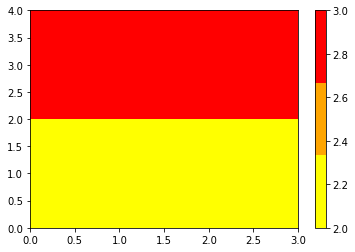

In [6]:
plt.pcolormesh(rm, cmap=cmap)
plt.colorbar()

In [7]:
import glob
data_dir = 'data/202107070000_Taranaki_high'
fname = '21070700_Taranaki_12.0_0.01.nc'
files = glob.glob('{}/**/{}'.format(data_dir,fname), recursive=True)
files.sort()
ds = xr.open_mfdataset(files, combine='nested', concat_dim=['nwp'])

In [8]:
ds_slice = ds['total_deposition'].isel(time=23)

In [9]:
ashbins = [0.01, .1, 1, 10]
probbins = [0., 0.5, 0.9, 1.]
rm2 = ensemble2riskmatrix(ds_slice, ashbins, probbins)
rm2_nan = np.ma.masked_array(rm2.astype(float), mask=rm2==0, fill_value=np.nan).filled()

In [10]:
ds_final = xr.Dataset({'risk': (['lat', 'lon'], rm2_nan)}, coords={'lon': ds.lon, 'lat': ds.lat})

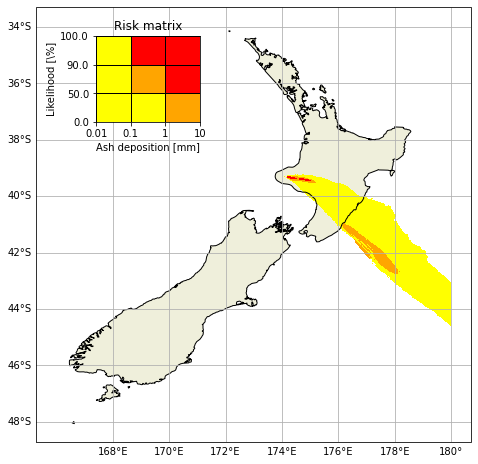

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
clon=180

# problem - plots land everywhere..
land_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", facecolor=cfeature.COLORS["land"]
)

def plot_decor(ax):
    ax.coastlines("10m")
    # ax.add_feature(ocean_10m, zorder=0)
    ax.add_feature(land_10m, zorder=-1)
    gl = ax.gridlines(xlocs=np.arange(168, 182, 2), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

def plot_risk_matrix(iax, ashbins, probbins):
    Z = np.array([[1, 1, 2],
                  [1, 2, 3],
                  [1, 3, 3]])
    x = np.arange(Z.shape[1] + 1)
    y = np.arange(Z.shape[0] + 1)
    iax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max(), cmap=cmap,
                  edgecolor='k')
    iax.set_xticks([0, 1., 2., 3.])
    iax.set_xticklabels(ashbins)
    iax.set_xlabel('Ash deposition [mm]')
    iax.set_yticks([0, 1., 2., 3.])
    iax.set_yticklabels(np.array(probbins)*100.)
    iax.set_ylabel('Likelihood [\%]')
    iax.set(title='Risk matrix')
    
fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw={"projection": ccrs.PlateCarree(clon)})
plot_decor(ax=ax)
ds_final['risk'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False)
# this is an inset axes over the main axes
ins_ax = fig.add_axes([.33, .68, .12, .15])
plot_risk_matrix(ins_ax, ashbins, probbins)

In [12]:
fig.savefig('plots/risk_matrix.png', bbox_inches='tight', dpi=200)